In [165]:
import numpy as np 
import sys
import pdb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder

def get_data(x_path, y_path):
    '''
    Args:
        x_path: path to x file
        y_path: path to y file
    Returns:
        x: np array of [NUM_OF_SAMPLES x n]
        y: np array of [NUM_OF_SAMPLES]
    '''
    x = np.load(x_path)
    y = np.load(y_path)

    x = x.astype('float')

    #normalize each example in x to have 0 mean and 1 std
    
    # Calculate the mean and standard deviation for each feature
    feature_means = np.mean(x, axis=0)
    feature_stds = np.std(x, axis=0)
    feature_stds = feature_stds + (feature_stds == 0)

    # Normalize each feature to have 0 mean and 1 std
    x = (x - feature_means) / (feature_stds)
    
    # Adjust labels to start from 0 if they start from 1
    y = y - 1
    
    return x, y

def get_metric(y_true, y_pred):
    '''
    Args:
        y_true: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
        y_pred: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
                
    '''
    results = classification_report(y_pred, y_true)
    print(results)

In [166]:
x_test, y_test = get_data('x_test.npy', 'y_test.npy')
x_train, y_train = get_data('x_train.npy', 'y_train.npy')

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10000, 1024), (10000,), (1000, 1024), (1000,))

In [167]:
x_train[0]

array([-0.39813868,  0.1879447 ,  0.91463024, ..., -0.15117837,
        0.26519742,  0.        ])

In [168]:
label_encoder = OneHotEncoder(sparse_output = False)
label_encoder.fit(np.expand_dims(y_train, axis = -1))

y_train_onehot = label_encoder.transform(np.expand_dims(y_train, axis = -1))
y_test_onehot = label_encoder.transform(np.expand_dims(y_test, axis = -1))

In [169]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        """
        Initializes the neural network with the given layer sizes.
        layer_sizes is a list of integers, where the i-th integer represents
        the number of neurons in the i-th layer.
        """
        self.layer_sizes = layer_sizes
        self.weights = []
        self.biases = []
        self.activations = []

        # Initialize weights and biases for each layer
        for i in range(len(layer_sizes) - 1):
            # Weights are initialized with small random values
            self.weights.append(np.random.randn(layer_sizes[i+1], layer_sizes[i]) * 0.01)
            self.biases.append(np.zeros((layer_sizes[i+1], 1)))

    def sigmoid(self, z):
        """
        The sigmoid activation function.
        """
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        """
        The softmax function.
        """
        e_z = np.exp(z)  # Subtracting np.max(z) for numerical stability
        return e_z / e_z.sum(axis=0, keepdims=True)

    def feedforward(self, x):
        """
        Performs a feedforward computation.
        """
        activation = x
        self.activations = [x]  # List to store all the activations, layer by layer

        # Compute activations for each layer
        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, activation) + b
            activation = self.sigmoid(z) if w is not self.weights[-1] else self.softmax(z)
            self.activations.append(activation)

        return self.activations[-1]  # The final activation is the output of the network

# Let's test the initialization and feedforward computation with a small network
nn = NeuralNetwork([1024, 100, 5])  # A network with 1024 input features, one hidden layer with 100 neurons, and 5 output classes
sample_input = np.random.randn(1024, 1)  # A random sample input
output = nn.feedforward(sample_input)  # Perform a feedforward computation

output  # Display the output probabilities

array([[0.21001698],
       [0.18440967],
       [0.20223693],
       [0.20182329],
       [0.20151313]])

In [173]:
class NeuralNetwork(NeuralNetwork):  # Extending the previously defined NeuralNetwork class
    def cross_entropy_loss(self, y_pred, y_true):
        """
        Computes the cross-entropy loss.
        """
        m = y_true.shape[1]  # Number of examples
        # To avoid division by zero, we clip the predictions to a minimum value
        # y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        # Compute the cross-entropy loss
        loss = -np.sum(y_true * np.log(y_pred)) / m
        return loss

    def backpropagation(self, y_true):
        """
        Performs backpropagation to compute the gradients of the loss function
        with respect to the weights and biases.
        """
        m = y_true.shape[1]  # Number of examples
        y_pred = self.activations[-1]  # The output of the last layer
        y_true = y_true.reshape(y_pred.shape)  # Ensure same shape

        # Initialize gradients for each layer
        d_weights = [np.zeros(w.shape) for w in self.weights]
        d_biases = [np.zeros(b.shape) for b in self.biases]

        # Calculate derivative of loss w.r.t. the last layer output
        d_loss = y_pred - y_true

        for i in reversed(range(len(d_weights))):
            d_activations = d_loss * self.sigmoid_derivative(self.activations[i+1]) if i != len(d_weights) - 1 else d_loss
            d_weights[i] = np.dot(d_activations, self.activations[i].T) / m
            d_biases[i] = np.sum(d_activations, axis=1, keepdims=True) / m
            if i != 0:
                d_loss = np.dot(self.weights[i].T, d_activations)

        return d_weights, d_biases

    def sigmoid_derivative(self, s):
        """
        Derivative of the sigmoid function.
        """
        return s * (1 - s)

    def update_parameters(self, d_weights, d_biases, learning_rate):
        """
        Updates the parameters using the computed gradients.
        """
        # Update each parameter with a simple gradient descent step
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * d_weights[i]
            self.biases[i] -= learning_rate * d_biases[i]
            
    def train(self, x_train, y_train, epochs, mini_batch_size, learning_rate, conv_threshold = 0.001, conv_epochs = 5):
        n = x_train.shape[1]  # Total number of training examples

        # Training loop
        loss_history = []
        permutation = np.random.permutation(n)
        for epoch in range(epochs):
            # Shuffle the training data for each epoch
            x_train_shuffled = x_train[:, permutation]
            y_train_shuffled = y_train[:, permutation]

            # Mini-batch loop
            for k in range(0, n, mini_batch_size):
                mini_batch_x = x_train_shuffled[:, k:k + mini_batch_size]
                mini_batch_y = y_train_shuffled[:, k:k + mini_batch_size]
                # Forward pass
                self.feedforward(mini_batch_x)
                # Backward pass
                d_weights, d_biases = self.backpropagation(mini_batch_y)
                # Update parameters
                self.update_parameters(d_weights, d_biases, learning_rate)
            
            loss = self.cross_entropy_loss(self.feedforward(x_train), y_train)
            # Optional: Print the loss after each epoch (can be commented out for speed)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")
            
            loss_history.append(loss)
            
            if len(loss_history) > conv_epochs:
                temp = loss_history[-conv_epochs:]
                if np.std(temp) < conv_threshold:
                    print('Converged')
                    break

In [174]:
# Create a fresh instance of the neural network with the corrected train method
nn = NeuralNetwork([1024, 100, 5])
# Convert labels to one-hot encoding again
y_train_one_hot = np.eye(5)[y_train].T

# Train the neural network again with the corrected training method
nn.train(x_train.T, y_train_one_hot, epochs=1000, mini_batch_size=32, learning_rate=0.01)

Epoch 1/1000, Loss: 1.3209
Epoch 2/1000, Loss: 0.9888
Epoch 3/1000, Loss: 0.8633
Epoch 4/1000, Loss: 0.7913
Epoch 5/1000, Loss: 0.7416
Epoch 6/1000, Loss: 0.7035
Epoch 7/1000, Loss: 0.6723
Epoch 8/1000, Loss: 0.6458
Epoch 9/1000, Loss: 0.6226
Epoch 10/1000, Loss: 0.6021
Epoch 11/1000, Loss: 0.5837
Epoch 12/1000, Loss: 0.5670
Epoch 13/1000, Loss: 0.5519
Epoch 14/1000, Loss: 0.5381
Epoch 15/1000, Loss: 0.5255
Epoch 16/1000, Loss: 0.5138
Epoch 17/1000, Loss: 0.5030
Epoch 18/1000, Loss: 0.4930
Epoch 19/1000, Loss: 0.4837
Epoch 20/1000, Loss: 0.4749
Epoch 21/1000, Loss: 0.4667
Epoch 22/1000, Loss: 0.4590
Epoch 23/1000, Loss: 0.4517
Epoch 24/1000, Loss: 0.4448
Epoch 25/1000, Loss: 0.4383
Epoch 26/1000, Loss: 0.4321
Epoch 27/1000, Loss: 0.4262
Epoch 28/1000, Loss: 0.4205
Epoch 29/1000, Loss: 0.4151
Epoch 30/1000, Loss: 0.4100
Epoch 31/1000, Loss: 0.4050
Epoch 32/1000, Loss: 0.4003
Epoch 33/1000, Loss: 0.3957
Epoch 34/1000, Loss: 0.3913
Epoch 35/1000, Loss: 0.3871
Epoch 36/1000, Loss: 0.3830
E

In [172]:
# Compute the accuracy on the training and test sets
y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
print(f"Training accuracy: {np.mean(y_train_pred == y_train) * 100}%")
print(f"Test accuracy: {np.mean(y_test_pred == y_test) * 100}%")

Training accuracy: 100.0%
Test accuracy: 86.2%


# part b

In [0]:
hidden_layer_sizes = [1, 5, 10, 50, 100]
model_with_hidden_layer_size = {}

for hidden_layer_size in hidden_layer_sizes:
    
    print(f'hidden_layer_size: {hidden_layer_size}')
    nn = NeuralNetwork([1024, hidden_layer_size, 5])
    nn.train(x_train.T, y_train_one_hot, epochs=1000, mini_batch_size=32, learning_rate=0.01)
    model_with_hidden_layer_size[hidden_layer_size] = nn

In [183]:
for hidden_layer_size in hidden_layer_sizes:
    nn = model_with_hidden_layer_size[hidden_layer_size]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred, y_train)
    print(f"{hidden_layer_size} hidden layer size")
    print('Training')
    print(results)
    
    results = classification_report(y_test_pred, y_test)
    print('Test')
    print(results)

1 hidden layer size
Training
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      2589
           1       0.63      0.89      0.74      1410
           2       0.78      0.85      0.81      1782
           3       0.40      0.73      0.52      1114
           4       0.98      0.66      0.79      3105

    accuracy                           0.76     10000
   macro avg       0.76      0.78      0.74     10000
weighted avg       0.84      0.76      0.78     10000

Test
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       258
           1       0.73      0.91      0.81       158
           2       0.67      0.78      0.72       170
           3       0.32      0.55      0.40       107
           4       0.98      0.60      0.74       307

    accuracy                           0.75      1000
   macro avg       0.74      0.75      0.72      1000
weighted avg       0.82      0.75      0.76

In [184]:
avg_f1_scores_training = []
avg_f1_scores_test = []
for hidden_layer_size in hidden_layer_sizes:
    nn = model_with_hidden_layer_size[hidden_layer_size]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred, y_train, output_dict=True)
    avg_f1_scores_training.append(results['weighted avg']['f1-score'])
    
    results = classification_report(y_test_pred, y_test, output_dict=True)
    avg_f1_scores_test.append(results['weighted avg']['f1-score'])

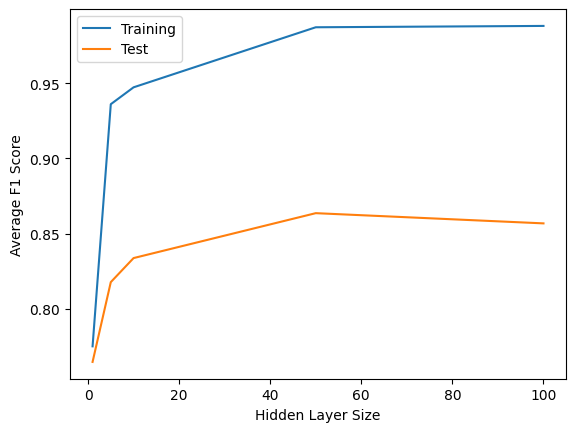

In [185]:
plt.plot(hidden_layer_sizes, avg_f1_scores_training, label = 'Training')
plt.plot(hidden_layer_sizes, avg_f1_scores_test, label = 'Test')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Average F1 Score')
plt.legend()
plt.savefig('(b) f1 vs hidden_size.png')

# part c

In [187]:
hidden_layers = [[512], [512, 256], [512, 256, 128], [512, 256, 128, 64]]
layers = [[1024] + hidden_layer + [5] for hidden_layer in hidden_layers]
model_with_hidden_layers = {}

for layer in layers:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train(x_train.T, y_train_one_hot, epochs=1000, mini_batch_size=32, learning_rate=0.01)
    model_with_hidden_layers[str(layer)] = nn

hidden_layer_size: [1024, 512, 5]
Epoch 1/1000, Loss: 1.1081
Epoch 2/1000, Loss: 0.8564
Epoch 3/1000, Loss: 0.7482
Epoch 4/1000, Loss: 0.6855
Epoch 5/1000, Loss: 0.6427
Epoch 6/1000, Loss: 0.6103
Epoch 7/1000, Loss: 0.5843
Epoch 8/1000, Loss: 0.5624
Epoch 9/1000, Loss: 0.5435
Epoch 10/1000, Loss: 0.5269
Epoch 11/1000, Loss: 0.5121
Epoch 12/1000, Loss: 0.4989
Epoch 13/1000, Loss: 0.4869
Epoch 14/1000, Loss: 0.4761
Epoch 15/1000, Loss: 0.4662
Epoch 16/1000, Loss: 0.4572
Epoch 17/1000, Loss: 0.4490
Epoch 18/1000, Loss: 0.4414
Epoch 19/1000, Loss: 0.4343
Epoch 20/1000, Loss: 0.4278
Epoch 21/1000, Loss: 0.4218
Epoch 22/1000, Loss: 0.4161
Epoch 23/1000, Loss: 0.4108
Epoch 24/1000, Loss: 0.4059
Epoch 25/1000, Loss: 0.4012
Epoch 26/1000, Loss: 0.3967
Epoch 27/1000, Loss: 0.3925
Epoch 28/1000, Loss: 0.3885
Epoch 29/1000, Loss: 0.3847
Epoch 30/1000, Loss: 0.3810
Epoch 31/1000, Loss: 0.3775
Epoch 32/1000, Loss: 0.3741
Epoch 33/1000, Loss: 0.3709
Epoch 34/1000, Loss: 0.3678
Epoch 35/1000, Loss: 0.

In [ ]:
for layer in layers[-2:]:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train(x_train.T, y_train_one_hot, epochs=1000, mini_batch_size=32, learning_rate=0.01, conv_threshold=1e-5)
    model_with_hidden_layers[str(layer)] = nn

In [ ]:
for layer in layers[-1:]:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train(x_train.T, y_train_one_hot, epochs=1000, mini_batch_size=32, learning_rate=0.1, conv_threshold=1e-5)
    model_with_hidden_layers[str(layer)] = nn

In [ ]:
# save models
import pickle

with open('model_with_hidden_layers.pickle', 'wb') as handle:
    pickle.dump(model_with_hidden_layers, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
for layer in layers:
    nn = model_with_hidden_layers[str(layer)]
    y_train_pred = np.argmax(nn.feedforward(x_train.T), axis=0)
    y_test_pred = np.argmax(nn.feedforward(x_test.T), axis=0)
    results = classification_report(y_train_pred, y_train)
    print(f"{layer} hidden layer size")
    print('Training')
    print(results)
    
    results = classification_report(y_test_pred, y_test)
    print('Test')
    print(results)

# part c

In [196]:
class NeuralNetwork(NeuralNetwork):  # Extending the previously defined NeuralNetwork class
    def train_c(self, x_train, y_train, epochs, mini_batch_size, learning_rate, conv_threshold = 0.001, conv_epochs = 5):
        n = x_train.shape[1]  # Total number of training examples

        # Training loop
        loss_history = []
        permutation = np.random.permutation(n)
        learning_rate_c = learning_rate
        for epoch in range(epochs):
            learning_rate = learning_rate_c / pow(epoch, 0.5)
            # Shuffle the training data for each epoch
            x_train_shuffled = x_train[:, permutation]
            y_train_shuffled = y_train[:, permutation]

            # Mini-batch loop
            for k in range(0, n, mini_batch_size):
                mini_batch_x = x_train_shuffled[:, k:k + mini_batch_size]
                mini_batch_y = y_train_shuffled[:, k:k + mini_batch_size]
                # Forward pass
                self.feedforward(mini_batch_x)
                # Backward pass
                d_weights, d_biases = self.backpropagation(mini_batch_y)
                # Update parameters
                self.update_parameters(d_weights, d_biases, learning_rate)
            
            loss = self.cross_entropy_loss(self.feedforward(x_train), y_train)
            # Optional: Print the loss after each epoch (can be commented out for speed)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")
            
            loss_history.append(loss)
            
            if len(loss_history) > conv_epochs:
                temp = loss_history[-conv_epochs:]
                if np.std(temp) < conv_threshold:
                    print('Converged')
                    break

In [198]:
models_d = {}
for layer in layers:
    print(f'hidden_layer_size: {layer}')
    nn = NeuralNetwork(layer)
    nn.train_c(x_train.T, y_train_one_hot, epochs=1000, mini_batch_size=32, learning_rate=0.01)
    models_d[str(layer)] = nn

# part f

In [ ]:
from sklearn.metrics import f1_score

models_f = {}
for hidden_layer in hidden_layers:
    print(f'hidden_layer_size: {hidden_layer}')
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer,
                        activation='relu',
                        solver='sgd',
                        alpha=0,
                        batch_size=32,
                        learning_rate='invscaling',
                        max_iter=200,
                        n_iter_no_change=5,
                        verbose=True)
    mlp.fit(x_train, y_train)
    
    models_f[str(hidden_layer_size)] = mlp

hidden_layer_size: [512]
Iteration 1, loss = 0.85098997
Iteration 2, loss = 0.59706419
Iteration 3, loss = 0.59042063
Iteration 4, loss = 0.58687388
Iteration 5, loss = 0.58450515
Iteration 6, loss = 0.58268417
Iteration 7, loss = 0.58117875
Iteration 8, loss = 0.57990014
Iteration 9, loss = 0.57877349
Iteration 10, loss = 0.57777492
Iteration 11, loss = 0.57685872
Iteration 12, loss = 0.57602095
Iteration 13, loss = 0.57523868
Iteration 14, loss = 0.57451889
Iteration 15, loss = 0.57384004
Iteration 16, loss = 0.57319678
Iteration 17, loss = 0.57259446
Iteration 18, loss = 0.57201568
Iteration 19, loss = 0.57147014
Iteration 20, loss = 0.57094349
Iteration 21, loss = 0.57044027
Iteration 22, loss = 0.56995713
Iteration 23, loss = 0.56948431
Iteration 24, loss = 0.56903466
Iteration 25, loss = 0.56860076
Iteration 26, loss = 0.56817817
Iteration 27, loss = 0.56777220
Iteration 28, loss = 0.56736976
Iteration 29, loss = 0.56698630
Iteration 30, loss = 0.56660851
Iteration 31, loss = 0.5

/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.84732109
Iteration 2, loss = 0.55792190
Iteration 3, loss = 0.55426019
Iteration 4, loss = 0.55205214
Iteration 5, loss = 0.55037141
Iteration 6, loss = 0.54900566
Iteration 7, loss = 0.54784589
Iteration 8, loss = 0.54681499
Iteration 9, loss = 0.54586764
Iteration 10, loss = 0.54501781
Iteration 11, loss = 0.54423312
Iteration 12, loss = 0.54349883
Iteration 13, loss = 0.54280202
Iteration 14, loss = 0.54214736
Iteration 15, loss = 0.54152301
Iteration 16, loss = 0.54093273
Iteration 17, loss = 0.54035979
Iteration 18, loss = 0.53981771
Iteration 19, loss = 0.53929209
Iteration 20, loss = 0.53877916
Iteration 21, loss = 0.53829075
Iteration 22, loss = 0.53781337
Iteration 23, loss = 0.53734835
Iteration 24, loss = 0.53690571
Iteration 25, loss = 0.53646692
Iteration 26, loss = 0.53604249
Iteration 27, loss = 0.53562578
Iteration 28, loss = 0.53522441
Iteration 29, loss = 0.53482673
Iteration 30, loss = 0.53444002


In [ ]:
# save models
import pickle

with open('pickles/models_f.pickle', 'wb') as handle:
    pickle.dump(models_f, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# load models
with open('pickles/models_f.pickle', 'rb') as handle:
    models_f = pickle.load(handle)